Credit risk modelling template

In [235]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import missingno as msno 
import seaborn as sns
import graphviz
import xgboost as xgb

from matplotlib import pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from scipy import stats


def plot_roc_curve(y_val, y_pred):

    df_preds = pd.DataFrame({'y_val':y_val, 'preds':y_pred})
    gini = 2 * roc_auc_score(df_preds.y_val, df_preds.preds) - 1
    ks = stats.ks_2samp(df_preds[df_preds['y_val'] == 0]['preds'], df_preds[df_preds['y_val'] == 1]['preds']).statistic
    print('GINI = %0.3f, KS = %0.3f' % (gini, ks))

    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    fig = plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, 'b--', label='%s AUC = %0.4f, GINI = %0.3f, KS = %0.2f' % ('Model: ', roc_auc, gini, ks))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=0, fontsize='small')
    plt.show()

## Loading data

In [2]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/credit_risk/cs-training.csv')

In [3]:
del df['Unnamed: 0']
df = df.rename(columns={'SeriousDlqin2yrs':'def_flag'})

In [4]:
df.head()

,def_flag,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [5]:
df.shape

(150000, 11)

## Train test split

We have to split it first to make sure that we won't use the information hidden in test set in feature engineering.

In [6]:
train, test = train_test_split(df, test_size = 0.1, random_state = 666, stratify=df.def_flag)
print(train.shape)
print(test.shape)
print(sum(train.def_flag)/train.shape[0])
print(sum(test.def_flag)/test.shape[0])
print(train._is_view)
print(test._is_view)

(135000, 11)
(15000, 11)
0.06683703703703704
0.06686666666666667
False
False


## Missing values

In [7]:
train.isnull().mean() * 100

def_flag                                 0.000000
RevolvingUtilizationOfUnsecuredLines     0.000000
age                                      0.000000
NumberOfTime30-59DaysPastDueNotWorse     0.000000
DebtRatio                                0.000000
MonthlyIncome                           19.822963
NumberOfOpenCreditLinesAndLoans          0.000000
NumberOfTimes90DaysLate                  0.000000
NumberRealEstateLoansOrLines             0.000000
NumberOfTime60-89DaysPastDueNotWorse     0.000000
NumberOfDependents                       2.600000
dtype: float64

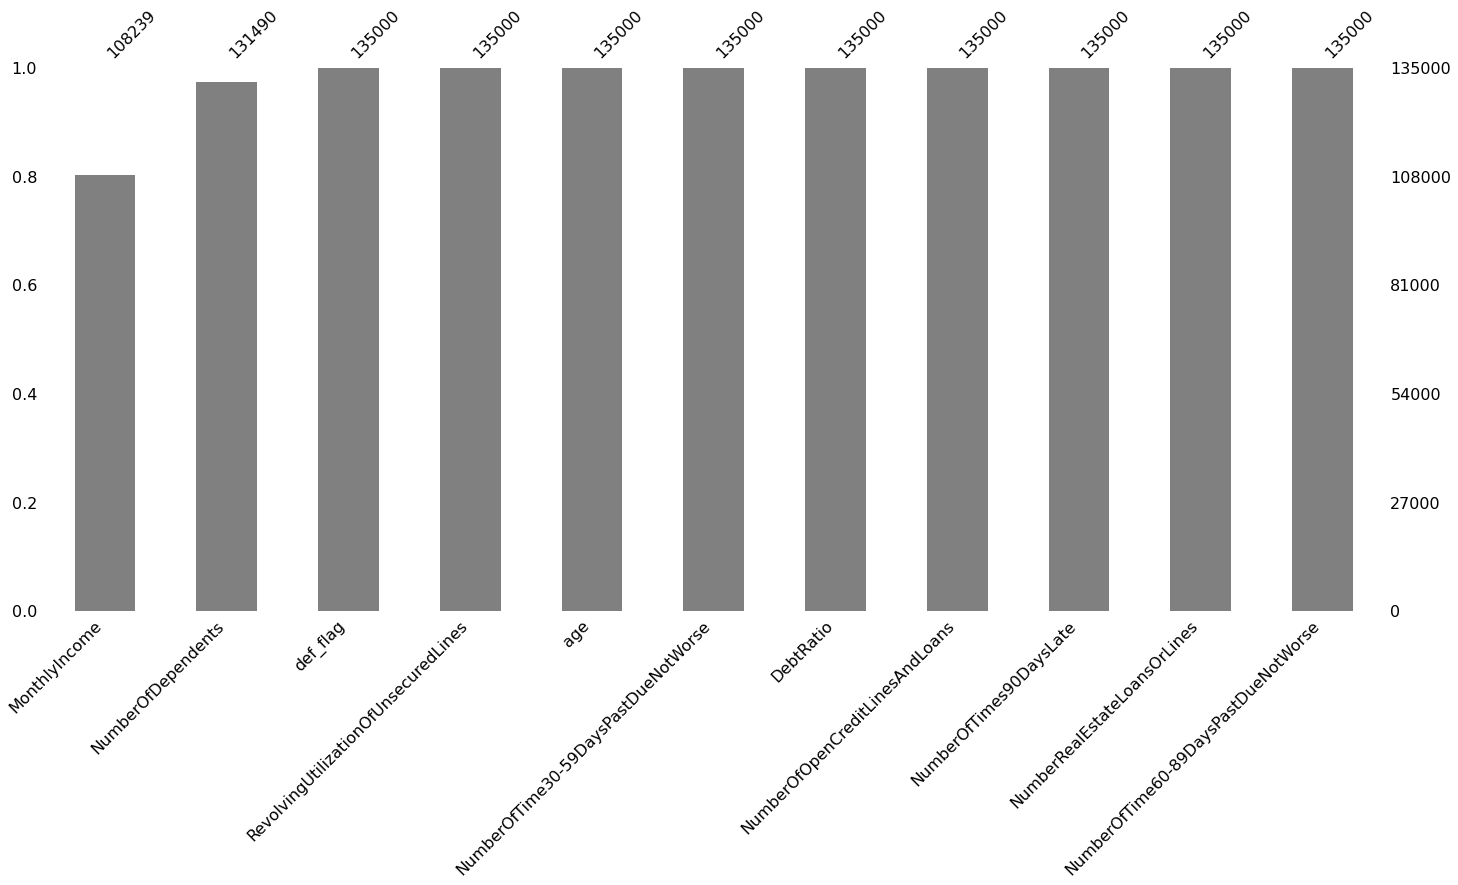

In [8]:
msno.bar(train, color='grey',sort='ascending',)

We do have some missing values in MonthlyIncome and NumberOfDependents so we are going to fill those with mean of those columns and create two new variables that indicate that those were inserted by hand.

In [9]:
train['income_insert'] = np.where(train['MonthlyIncome'].isna(), 1, 0)
train['dependents_insert'] = np.where(train['NumberOfDependents'].isna(), 1, 0)
# doing the same for test set
test['income_insert'] = np.where(test['MonthlyIncome'].isna(), 1, 0)
test['dependents_insert'] = np.where(test['NumberOfDependents'].isna(), 1, 0)

print(sum(train.MonthlyIncome.isna()))
print(sum(train.NumberOfDependents.isna()))

train['MonthlyIncome'] = train.MonthlyIncome.fillna(round(train.MonthlyIncome.mean(),0))
train['NumberOfDependents'] = train.NumberOfDependents.fillna(round(train.NumberOfDependents.mean(),0))
# filling rows of test set with means from train set
test['MonthlyIncome'] = test.MonthlyIncome.fillna(round(test.MonthlyIncome.mean(),0))
test['NumberOfDependents'] = test.NumberOfDependents.fillna(round(test.NumberOfDependents.mean(),0))

print(sum(train.MonthlyIncome.isna()))
print(sum(train.NumberOfDependents.isna()))

26761
3510
0
0


## Histograms

Let's briefly check all distributions 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f137a7c2a58>,
      dtype=object)

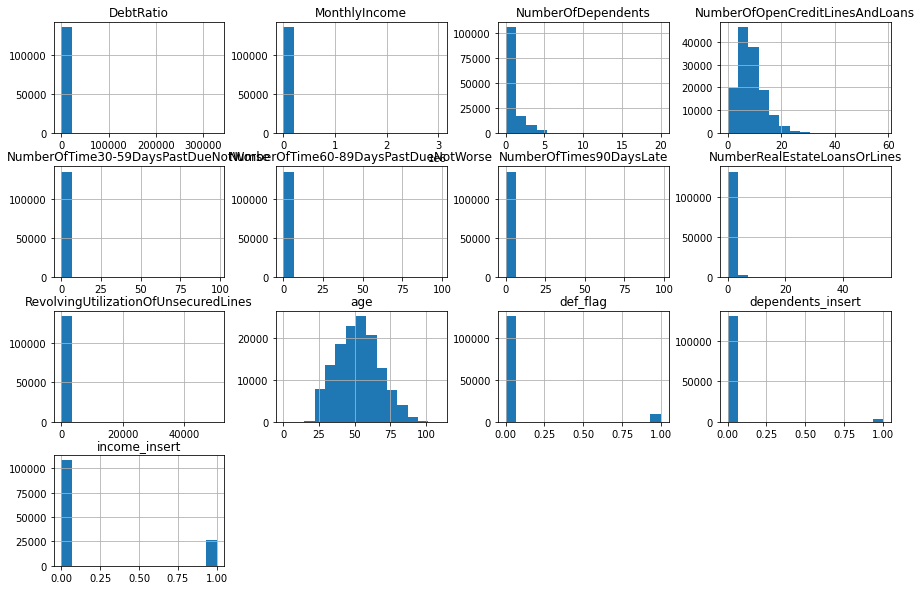

In [11]:
train.hist(bins=15, figsize=(15, 10))

## Outliers

In [63]:
train.describe()

,def_flag,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,135000.000000,135000.000000,135000.000000,135000.000000,135000.000000,1.082380e+05,135000.000000,135000.000000,135000.000000,135000.000000,131500.000000
mean,0.066889,6.214164,52.298178,0.423652,353.711742,6.676530e+03,8.457726,0.268570,1.017600,0.242993,0.757027
std,0.249830,258.878027,14.770696,4.225181,2090.422189,1.498363e+04,5.147515,4.202124,1.133377,4.187957,1.115610
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029674,41.000000,0.000000,0.175101,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.153318,52.000000,0.000000,0.366415,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.557778,63.000000,0.000000,0.868194,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Interquartile Range (IQR)

In [13]:
Q1 = train.quantile(0.25)
Q3 = train.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

def_flag                                   0.000000
RevolvingUtilizationOfUnsecuredLines       0.528828
age                                       22.000000
NumberOfTime30-59DaysPastDueNotWorse       0.000000
DebtRatio                                  0.693661
MonthlyIncome                           3484.000000
NumberOfOpenCreditLinesAndLoans            6.000000
NumberOfTimes90DaysLate                    0.000000
NumberRealEstateLoansOrLines               2.000000
NumberOfTime60-89DaysPastDueNotWorse       0.000000
NumberOfDependents                         1.000000
income_insert                              0.000000
dependents_insert                          0.000000
dtype: float64


Skewness

In [15]:
print(train['MonthlyIncome'].skew())
train['MonthlyIncome'].describe()

128.27872343912765


count    1.350000e+05
mean     6.671172e+03
std      1.326590e+04
min      0.000000e+00
25%      3.916000e+03
50%      6.600000e+03
75%      7.400000e+03
max      3.008750e+06
Name: MonthlyIncome, dtype: float64

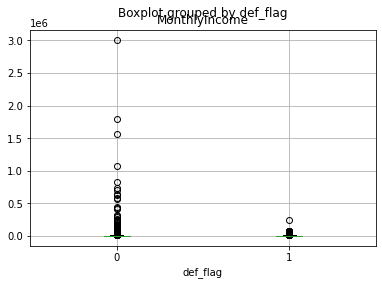

In [24]:
train.boxplot(column='MonthlyIncome', by = 'def_flag')

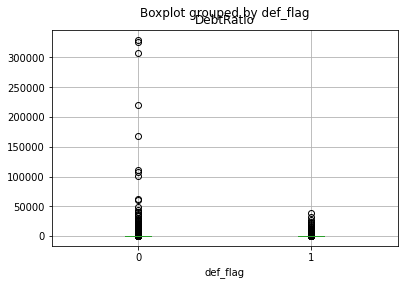

In [29]:
train.boxplot(column='DebtRatio', by = 'def_flag')

Quantile-based Flooring and Capping

For monthly income:

In [28]:
print(train['MonthlyIncome'].quantile(0.05))
print(train['MonthlyIncome'].quantile(0.85))

train["MonthlyIncome"] = np.where(train["MonthlyIncome"] < train['MonthlyIncome'].quantile(0.05),
                                  train['MonthlyIncome'].quantile(0.05),
                                  train['MonthlyIncome'])

train["MonthlyIncome"] = np.where(train["MonthlyIncome"] > train['MonthlyIncome'].quantile(0.85),
                                  train['MonthlyIncome'].quantile(0.85),
                                  train['MonthlyIncome'])
print(train["MonthlyIncome"].skew())

1500.0
9400.0
-0.15573017196166006


For debt ratio:

In [37]:
print(train['DebtRatio'].quantile(0.9))

train["DebtRatio"] = np.where(train["DebtRatio"] > train['DebtRatio'].quantile(0.9),
                                  train['DebtRatio'].quantile(0.9),
                                  train['DebtRatio'])
print(train["DebtRatio"].skew())

1265.0
2.17981790166222


For RevolvingUtilizationOfUnsecuredLines

In [38]:
print(train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.1))
print(train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.9))

train["RevolvingUtilizationOfUnsecuredLines"] = np.where(train["RevolvingUtilizationOfUnsecuredLines"] < train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.1),
                                  train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.1),
                                  train['RevolvingUtilizationOfUnsecuredLines'])

train["RevolvingUtilizationOfUnsecuredLines"] = np.where(train["RevolvingUtilizationOfUnsecuredLines"] > train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.9),
                                  train['RevolvingUtilizationOfUnsecuredLines'].quantile(0.9),
                                  train['RevolvingUtilizationOfUnsecuredLines'])
print(train["RevolvingUtilizationOfUnsecuredLines"].skew())

0.0
0.8536305365500001
0.874604917609266


## WoE

In [ ]:
# TODO

## Normalization

In [ ]:
# TODO

## Correlations

In [47]:
corr = train.corr(method ='pearson')

In [51]:
corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)

,def_flag,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,income_insert,dependents_insert
def_flag,1.00,0.28,-0.12,0.13,-0.02,-0.06,-0.03,0.12,-0.01,0.10,0.04,-0.02,-0.01
RevolvingUtilizationOfUnsecuredLines,0.28,1.00,-0.28,0.12,-0.04,-0.12,-0.16,0.11,-0.07,0.10,0.08,-0.06,-0.04
age,-0.12,-0.28,1.00,-0.06,0.06,0.13,0.15,-0.06,0.03,-0.06,-0.21,0.14,0.08
NumberOfTime30-59DaysPastDueNotWorse,0.13,0.12,-0.06,1.00,-0.02,-0.03,-0.05,0.98,-0.03,0.99,-0.00,0.02,0.02
DebtRatio,-0.02,-0.04,0.06,-0.02,1.00,0.08,0.03,-0.02,0.11,-0.02,-0.10,0.76,0.16
MonthlyIncome,-0.06,-0.12,0.13,-0.03,0.08,1.00,0.23,-0.03,0.31,-0.03,0.15,0.17,0.06
NumberOfOpenCreditLinesAndLoans,-0.03,-0.16,0.15,-0.05,0.03,0.23,1.00,-0.08,0.43,-0.07,0.06,-0.12,-0.09
NumberOfTimes90DaysLate,0.12,0.11,-0.06,0.98,-0.02,-0.03,-0.08,1.00,-0.04,0.99,-0.01,0.03,0.02
NumberRealEstateLoansOrLines,-0.01,-0.07,0.03,-0.03,0.11,0.31,0.43,-0.04,1.00,-0.04,0.12,-0.07,-0.06
NumberOfTime60-89DaysPastDueNotWorse,0.10,0.10,-0.06,0.99,-0.02,-0.03,-0.07,0.99,-0.04,1.00,-0.01,0.03,0.02


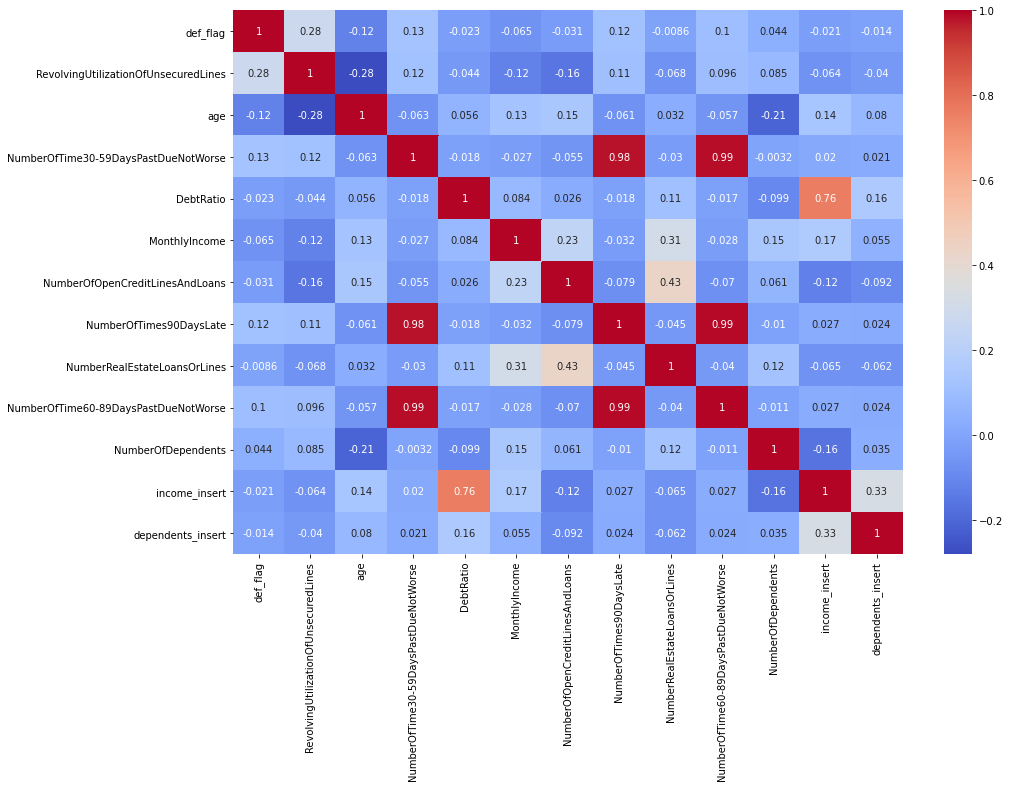

In [53]:
plt.figure(figsize=(15, 10))
sns.heatmap(corr, cmap='coolwarm',annot=True)

## Cross tabs

In [46]:
purp_loan= ['NumberOfDependents', 'def_flag']
cm = sns.light_palette("green", as_cmap=True)
(round(pd.crosstab(train[purp_loan[0]], train[purp_loan[1]], 
                   normalize='columns') * 100,2)).style.background_gradient(cmap = cm)

def_flag,0,1
NumberOfDependents,,
0.0,58.420000,51.040000
1.0,20.090000,20.950000
2.0,12.830000,15.670000
3.0,6.160000,8.370000
4.0,1.850000,3.010000
5.0,0.490000,0.640000
6.0,0.090000,0.240000
7.0,0.030000,0.060000
8.0,0.020000,0.020000


## Training

In [59]:
X = train.loc[:, train.columns != 'def_flag']
y = train['def_flag']

Train/validation split

In [128]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 666, stratify = y)

### Logit

In [174]:
logit = LogisticRegression(max_iter=1000,random_state=666)

In [175]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=666, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [176]:
logit_preds = logit.predict_proba(X_val)[:,-1]

In [177]:
logit_auc = roc_auc_score(y_val,logit_preds)
print(f'Gini: {round(2*logit_auc - 1,3)}')

Gini: 0.567


GINI = 0.567, KS = 0.449


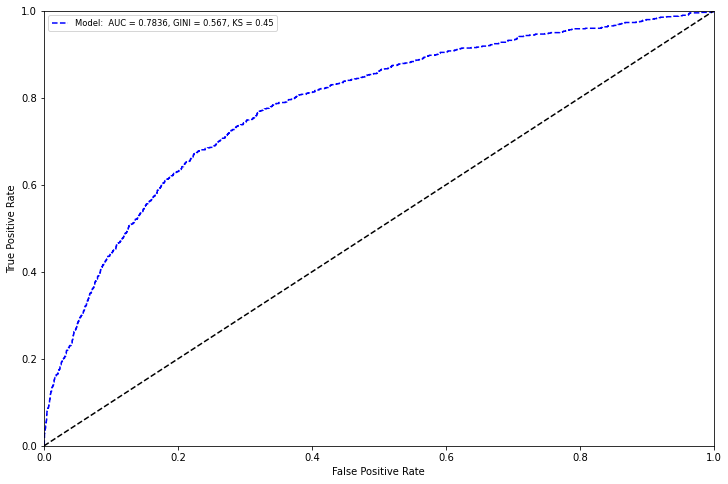

In [240]:
plot_roc_curve(y_val, logit_preds)

### Decision tree

In [75]:
dt = tree.DecisionTreeClassifier(max_depth = 5)

In [76]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [145]:
dt_preds = dt.predict_proba(X_val)[:,-1]

In [148]:
dt_auc = roc_auc_score(y_val,dt_preds)
print(f'Gini: {round(2*dt_auc - 1,3)}')

Gini: 0.691


GINI = 0.691, KS = 0.562


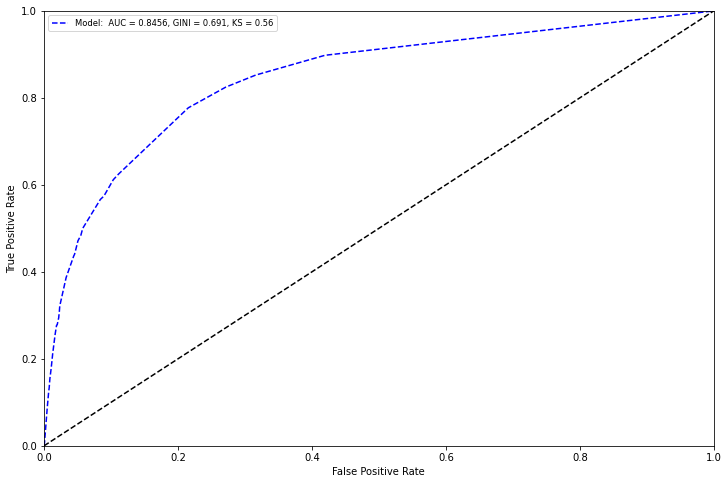

In [239]:
plot_roc_curve(y_val, dt_preds)

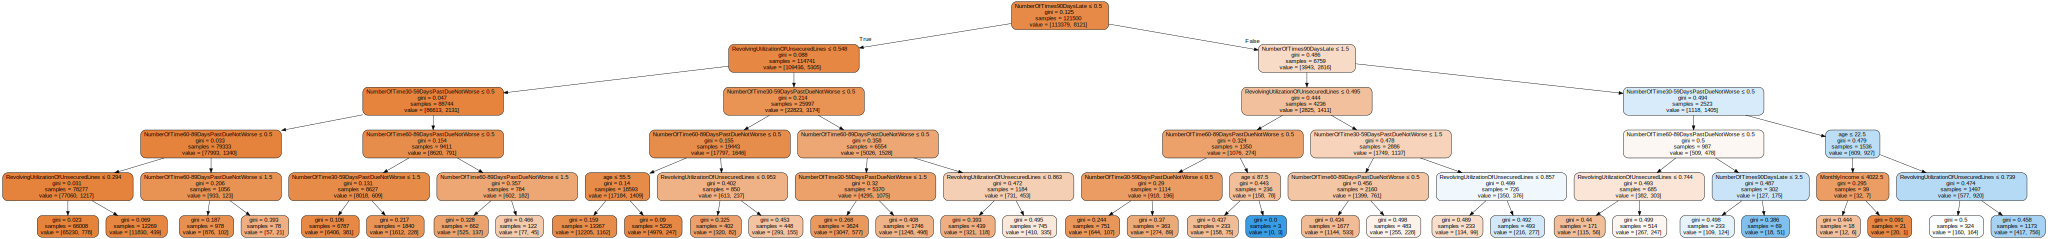

In [92]:
dot_data = tree.export_graphviz(dt, out_file=None, 
                     feature_names=X_train.columns,   
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

### Random Forest

In [118]:
rf = RandomForestClassifier(n_estimators=200)

In [119]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [143]:
rf_preds = rf.predict_proba(X_val)[:,-1]
rf_auc = roc_auc_score(y_val,rf_preds)
print(f'Gini: {round(2*rf_auc - 1,3)}')

Gini: 0.692


GINI = 0.692, KS = 0.548


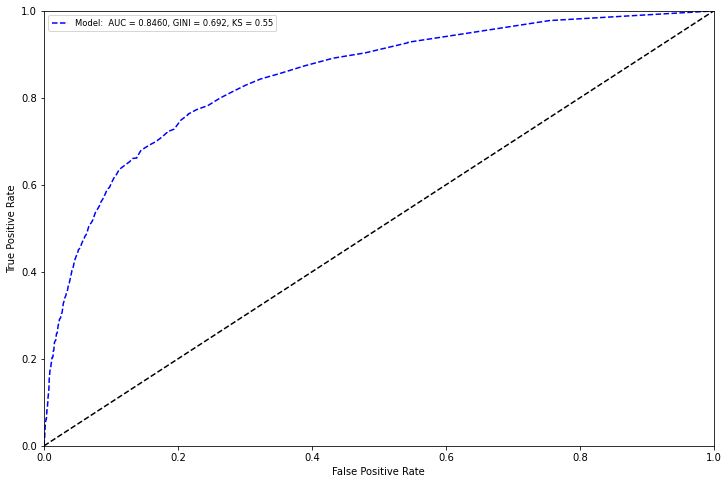

In [238]:
plot_roc_curve(y_val, rf_preds)

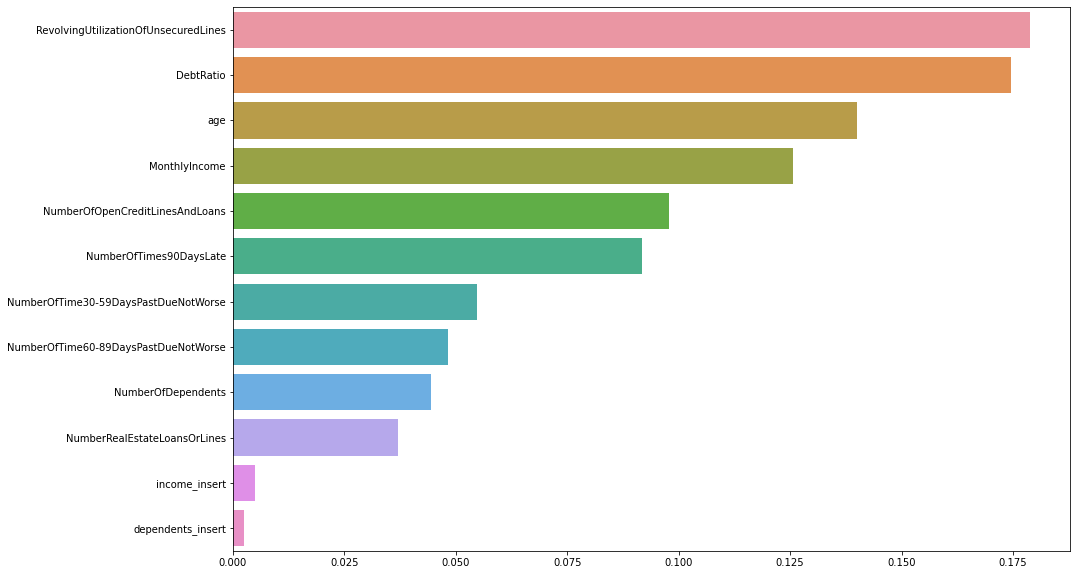

In [158]:
feature_imp = pd.Series(rf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(15, 10))
sns.barplot(x=feature_imp, y=feature_imp.index)

### AdaBoost

In [163]:
ada = AdaBoostClassifier()

In [164]:
ada.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [166]:
ada_preds = ada.predict_proba(X_val)[:,-1]
ada_auc = roc_auc_score(y_val,ada_preds)
print(f'Gini: {round(2*ada_auc - 1,3)}')

Gini: 0.717


GINI = 0.717, KS = 0.566


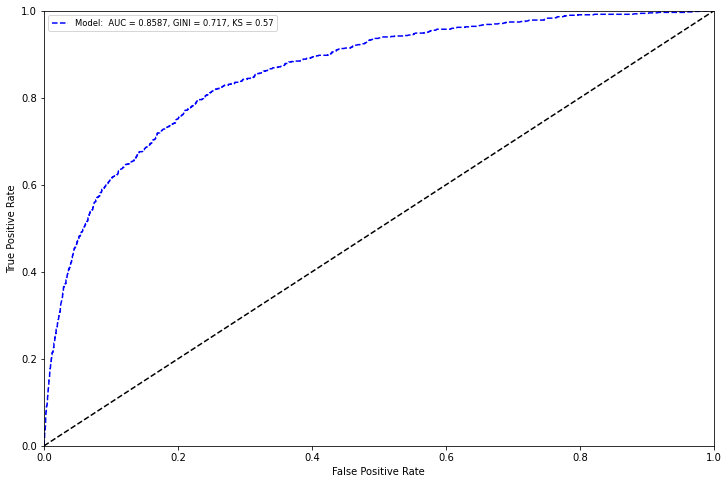

In [237]:
plot_roc_curve(y_val, ada_preds)

### XGBoost

In [236]:
train_dmatrix = xgb.DMatrix(data=X_train,label=y_train)
test_dmatrix = xgb.DMatrix(data=X_val)

param = {'max_depth': 4,
         'eta': 0.3,
         'gamma': 0,
         'subsample': 0.7,
         'colsample_bytree': 0.85,
         'scale_pos_weight': 4,
         'lambda': 1,
         'alpha': 0,
         'max_delta_step':0,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'
         }

xgb_model = xgb.train(params=param, dtrain=train_dmatrix, num_boost_round=100)

In [224]:
xgb_preds = xgb_model.predict(test_dmatrix)
xgb_auc = roc_auc_score(y_val,xgb_preds)
print(f'Gini: {round(2*xgb_auc - 1,3)}')

Gini: 0.732


GINI = 0.732, KS = 0.579


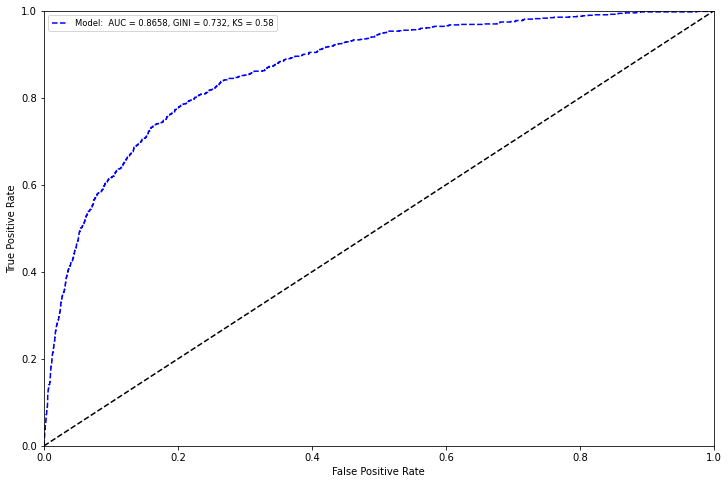

In [234]:
plot_roc_curve(y_val, xgb_preds)

## Comparison

In [247]:
aucs = [logit_auc, dt_auc, rf_auc, ada_auc, xgb_auc]
models = ['logit', 'decision_tree', 'random_forest', 'adaboost', 'xgboost']
df_compare = pd.DataFrame(zip(models, aucs), columns=['model','auc'])

In [249]:
df_compare['gini'] = 2*df_compare.auc - 1

In [250]:
df_compare

,model,auc,gini
0,logit,0.783646,0.567292
1,decision_tree,0.845589,0.691178
2,random_forest,0.858688,0.717377
3,adaboost,0.858688,0.717377
4,xgboost,0.865776,0.731552


In [ ]:
# TODO: compare on test set, plot rocs